In [1]:
import pickle
import pandas as pd
import os
import numpy as np
import import_ipynb
from feeds import BackFeed,DataFeed
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree
import graphviz
import seaborn as sns
import warnings
from utils import read_yaml, extract_suffix, remove_extension
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
from decision_tree import DecisionTree
from add_features import add_features, discretize

importing Jupyter notebook from feeds.ipynb
importing Jupyter notebook from synfeed.ipynb
importing Jupyter notebook from india_calendar.ipynb
importing Jupyter notebook from featfuncs.ipynb


In [3]:
config_name = 'rl_all_1.yaml'
config = read_yaml(os.path.join('configs', config_name))

use_raw_features = config.get('old_features', True)
use_new_features = config.get('new_features', False)
create_feed = config.get('create_feed', False)
dynamic_test = config.get('dynamic_test_features', False)
use_prediscrete = config.get('use_prediscrete', False)
modelname = config.get('modelname', f'{config_name.rstrip(".yaml")}.pth')
modify_name = config.get('modify_name', True)
if modify_name:
    modelname = f'{modelname.rstrip(".pth")}_{use_raw_features}_{use_new_features}.pth'
datafolder_name = 'alldata'

print(modelname)

RLC0_False_True.pth


In [4]:
feed_path = os.path.join('..', 'algodata', 'realdata', 
            f'datafeed_{datafolder_name}_{use_raw_features}_{use_new_features}_{use_prediscrete}.pkl')   
test_path = os.path.join('results', config_name.rstrip('.yaml'), 'test', 'realdata', datafolder_name, 'bt.pkl')

data_1 = pickle.load(open(test_path, 'rb'))
feed = pickle.load(open(feed_path, 'rb')).data
print(feed_path, test_path)

../algodata/realdata/datafeed_alldata_False_True_False.pkl results/rl_all_1/test/realdata/alldata/bt.pkl


In [5]:
for ticker in feed:
    print(ticker, end=', ')
    feed[ticker]['row_num'] = feed[ticker]['row_num'].apply(lambda x: x if x<75 else x-75)

NTPC.NS, DCM.NS, ACC.NS, TECHM.NS, MRF.NS, SUNPHARMA.NS, BPCL.NS, RELIANCE.NS, MUTHOOTFIN.NS, HINDUNILVR.NS, HDFC.NS, POWERGRID.NS, WIPRO.NS, PFC.NS, PETRONET.NS, DRREDDY.NS, ABBOTINDIA.NS, TCS.NS, BOSCHLTD.NS, KOTAKBANK.NS, SBIN.NS, MARUTI.NS, 

In [6]:
with open('additional_utils/cols.pkl', 'rb') as f:
        d = pickle.load(f)
imp_cols = d['imp_cols']
cols_to_use = d['cols_to_use']
prediscrete_imp_cols = d['prediscrete_imp_cols']

In [7]:
if use_raw_features and not use_new_features:
    for ticker in feed:
        print(f'[INFO] On ticker={ticker}')
        df = feed[ticker]
        df, pre_discrete_cols, discrete_cols = add_features(df, columns_to_use=cols_to_use)
        feed[ticker] = df
        
elif use_prediscrete:
    for ticker in feed:
        print(f'[INFO] On ticker={ticker}')
        df = feed[ticker]
        for col in df.columns:
            # if datatype of column is int or float
            if df[col].dtype in ['int64', 'float64']:
                df, names = discretize(df, col)
        feed[ticker] = df

### Adding Action Taken by Agent

### 0: Wait, 1: Buy, 2:Sell

In [8]:
actions = {}
for ticker in feed:
    feed[ticker]['Action'] = -5

    for t in data_1[ticker]:
        for acts in data_1[ticker][t]['acts']:
            a, rn = acts[0], acts[-1]
            actions[a] = actions.get(a, 0) + 1
            # if a == -1: a = 2
            slice = feed[ticker].loc[(feed[ticker]['Date']==t) & (feed[ticker]['row_num']==rn), 'Action']
            # if len(slice) != 1: print(ticker, t, rn)
            feed[ticker].loc[(feed[ticker]['Date']==t) & (feed[ticker]['row_num']==rn), 'Action'] = a
# print(actions)

In [9]:
actions

{-1: 869, 1: 663}

In [10]:
feed_old = feed.copy()
feed = pd.concat([feed[t] for t in feed], axis=0)
feed

,Open-Close_ma_1-Open-Close_ma_10_val,Close_slope_1_polarity,Volume_ma_10_val,Open-Close_slope_1_val,MACDs_12_26_9_ma_20_changelen_val,Open-Close_ma_1-Open-Close_ma_50_val,BBP_5_2.0_slope_1_changelen_val,BBM_5_2.0_ma_1-BBM_5_2.0_ma_20_changelen_val,Open-High_ma_5-Open-High_ma_20_changelen_val,BBL_5_2.0_ma_5_slope_1_changelen_polarity,...,Date,datetime,row_num,Close_n,Open_n,Open,Close,High,Low,Action
datetime,,,,,,,,,,,,,,,,,,,,,
2022-02-02 09:15:00+05:30,1,1,2,0,1,1,1,1,1,-1,...,02-Feb-2022,2022-02-02 09:15:00+05:30,0,1.001757,0.997189,141.899994,142.550003,142.600006,141.699997,-5
2022-02-02 09:20:00+05:30,2,-1,1,2,1,2,0,1,2,-1,...,02-Feb-2022,2022-02-02 09:20:00+05:30,1,0.999649,1.002460,142.649994,142.250000,142.649994,142.149994,-5
2022-02-02 09:25:00+05:30,2,-1,1,2,1,2,0,1,2,1,...,02-Feb-2022,2022-02-02 09:25:00+05:30,2,0.995081,1.000000,142.300003,141.600006,142.350006,141.600006,-5
2022-02-02 09:30:00+05:30,1,-1,1,0,1,1,2,1,2,-1,...,02-Feb-2022,2022-02-02 09:30:00+05:30,3,0.993675,0.995081,141.600006,141.399994,141.600006,141.350006,-5
2022-02-02 09:35:00+05:30,0,1,1,0,1,0,2,1,2,1,...,02-Feb-2022,2022-02-02 09:35:00+05:30,4,0.994378,0.994027,141.449997,141.500000,141.550003,141.199997,-5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 15:05:00+05:30,1,-1,0,1,0,1,2,1,2,-1,...,31-Dec-2021,2021-12-31 15:05:00+05:30,70,1.012182,1.012304,7420.899902,7420.000000,7430.000000,7418.000000,-5
2021-12-31 15:10:00+05:30,0,1,0,1,0,0,2,1,1,1,...,31-Dec-2021,2021-12-31 15:10:00+05:30,71,1.013157,1.012216,7420.250000,7427.149902,7429.450195,7417.000000,-5
2021-12-31 15:15:00+05:30,1,1,0,1,0,1,0,1,0,1,...,31-Dec-2021,2021-12-31 15:15:00+05:30,72,1.013177,1.013157,7427.149902,7427.299805,7433.549805,7422.149902,-5


In [11]:
feed['Action'].value_counts()

-5    204965
-1       685
 1       537
Name: Action, dtype: int64

### Creating Final DataFrame

In [15]:
df = feed[feed['Action']!=-5]
labels = ['sell', 'buy']

### Training a DT

In [16]:
def trainDT(X_train, X_test, y_train, y_test, cols_to_use, y_col, max_depth=2):
    # Fit the classifier with default hyper-parameters
    clf = DecisionTreeClassifier(max_depth=max_depth)
    model = clf.fit(X_train, y_train)
    
    # DOT data
    dot_data = tree.export_graphviz(clf, out_file=None,
                                    feature_names=cols_to_use,
                                    class_names=labels,
                                    filled=True)
    # Draw graph
    graph = graphviz.Source(dot_data, format="png")
    preds = clf.predict(X_test)
    cm = pd.DataFrame(confusion_matrix(y_test, preds), columns=labels, index=labels)
    report = classification_report(y_test, preds, target_names=labels)
    
    return graph, cm, report

[INFO] Using 25 columns!


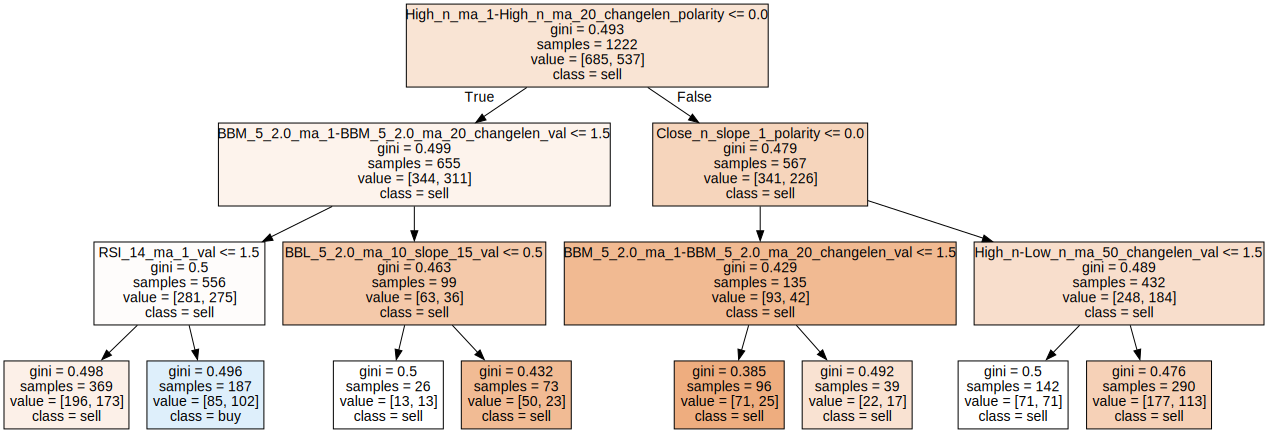

In [17]:
COLS_TO_USE =  [col for col in imp_cols]
print(f'[INFO] Using {len(COLS_TO_USE)} columns!')
y_col='Action'

n = len(df)
X = df.loc[:, COLS_TO_USE]
y = df.loc[:, y_col]

X_train, X_test, y_train, y_test = X.iloc[:n//2], X.iloc[n//2:], y.iloc[:n//2].values, y.iloc[n//2:].values

# graph, cm, report = trainDT(X_train, X_test, y_train, y_test, COLS_TO_USE, y_col=y_col, max_depth=2)
graph, cm, report = trainDT(X, X, y, y, COLS_TO_USE, y_col=y_col, max_depth=3) 
graph

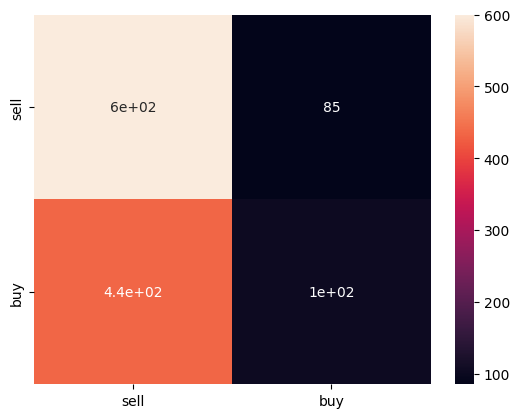

In [18]:
sns.heatmap(cm, annot=True);

In [19]:
print(report)


              precision    recall  f1-score   support

        sell       0.58      0.88      0.70       685
         buy       0.55      0.19      0.28       537

    accuracy                           0.57      1222
   macro avg       0.56      0.53      0.49      1222
weighted avg       0.56      0.57      0.51      1222



In [35]:
dt = DecisionTree(max_depth=3)
dt.train(X, y)

# dt.score(X_test, y.iloc[n//2:])

[INFO] Trained Tree!


In [36]:
dt.score(X, y)

              precision    recall  f1-score   support

          -1       0.58      0.88      0.70       685
           1       0.55      0.19      0.28       537

    accuracy                           0.57      1222
   macro avg       0.56      0.53      0.49      1222
weighted avg       0.56      0.57      0.51      1222



In [34]:
dt.visualize()

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             Index: 0
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [66]:
dt.prune(impurity_thresh=0.4, set_action=0)

[INFO] Pruned leaf with index: 3 as                           impurity=0.4852834028890922
[INFO] Prune leaf with index: 4 as                           impurity=0.4034434453610469
[INFO] Pruned leaf with index: 5 as                           impurity=0.27603486506255714
[INFO] Pruning complete!


In [67]:
dt.visualize()

                                                                                                         Index: 0
                                                                                                         row_num_slope_15_changelen_polarity >= 1
                                                                                                         Gini: 0.3366066778036487
                                                                                                         Samples: 3189
                                                                                                         Values: {-1: 2506, 1: 683}
                                                                                                         Class: -1

                                   Index: 1                                                                                                                                    Index: 2
                                   BBU_5_2.0_ma_1-BBU_5_2.0

In [28]:
dt.score(X, y)

              precision    recall  f1-score   support

          -1       0.93      0.84      0.88       432
           0       0.00      0.00      0.00         0
           1       0.97      0.77      0.86       490

    accuracy                           0.80       922
   macro avg       0.63      0.54      0.58       922
weighted avg       0.95      0.80      0.87       922



/Users/rishabh/miniforge3/envs/metarl/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rishabh/miniforge3/envs/metarl/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rishabh/miniforge3/envs/metarl/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
dt.save('saved_models/dt_hp_11.pkl')